In [1]:
import sys
import os

#Tell python where Mantid is installed.
#The official packages put this information in an environment variable called "MANTIDPATH"
sys.path.append(os.environ['MANTIDPATH'])

#Also adds the folder where 

#We can now import Mantid's Python API
from mantid.simpleapi import *

#Import matplotlib's pyplot interface under the name 'plt'
import matplotlib.pyplot as plt

#Some magic to tell matplotlib how to behave in IPython Notebook
%matplotlib inline

Now we run the reduction on a 5 K long dataset of Yb$_2$Ti$_2$O$_7$. The run number is `22038`, the run number of the corresponding vanadium standard measurement is `22034`, and that of the vanadium with a white beam (Fermi chopper removed), which is used to calibrate the detector efficiencies and determine faulty detectors is `21943`. The sample mass is 19g and its relative molecular mass is calculated from the elemental relative atomic mass as given in Webelements. The run used E$_i$=200 meV, and the energy bins for the conversion from ToF to energy transfer is given explicitly.

In [2]:
from MARIReduction_2016_5 import *

wbvan = 21943
sum_runs = False
remove_bkg = True
sam_mass = 19
sam_rmm = 2*173.05 + 2*47.867 + 7*16
monovan = 22034
runno = 22038
ei = 200
iliad_mari(runno,ei,wbvan,monovan,sam_mass,sam_rmm,sum_runs,check_background=remove_bkg, 
           energy_bins=[-100,0.5,195])

****************************************************************
*** ISIS CONVERT TO ENERGY TRANSFER WORKFLOW STARTED  **********
*** Loading or retrieving sample run: 22038
****************************************************************
****************************************************************
*** Sample run SR_MAR022038 properties change default reduction properties: 
****************************************************************
  Value of : bkgd_range                is set to : (18000, 19000)       
****************************************************************
****************************************************************
*** Output will be in absolute units of mb/str/mev/fu
*** Provisional Incident energy:      200.000 mEv
****************************************************************
  Value of : save_file_name            is set to : MAR22038_Ei200.00meV 
  Value of : bkgd_range                is set to : (18000, 19000)       
  Value of : incident_energy        

Now make energy cuts at low and high $|Q|$, and Q-cuts at the energy of the CF levels, and for the phonons at lower energies, and plot the cuts.

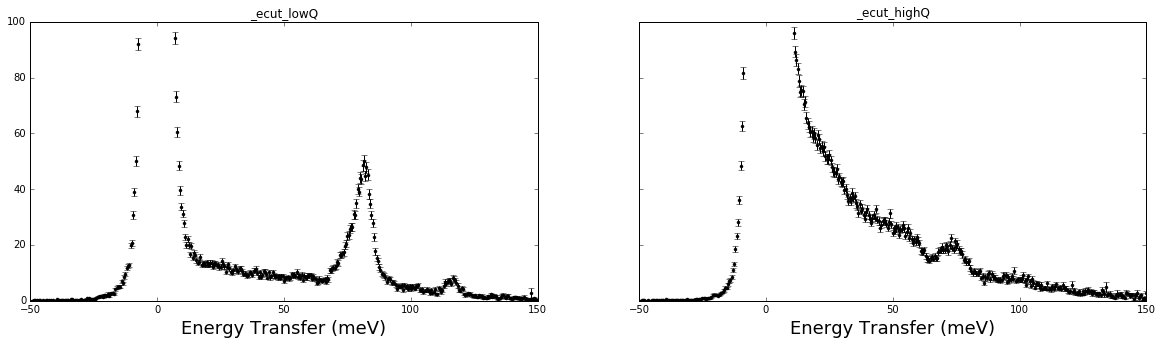

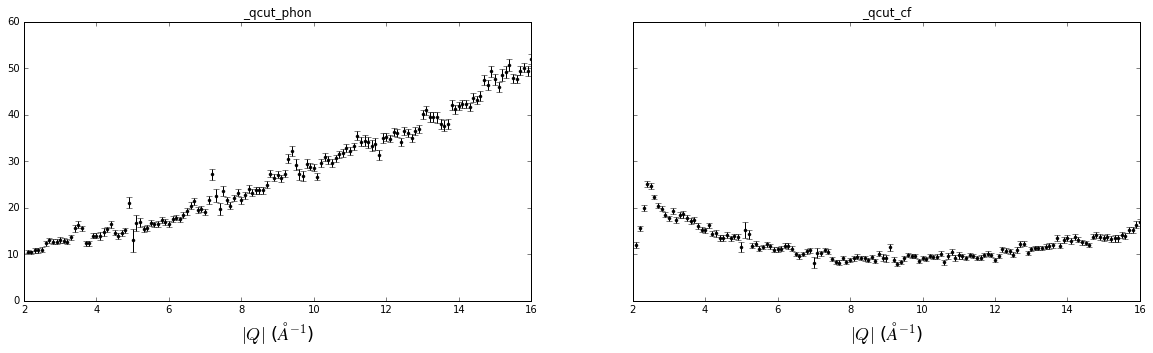

In [3]:
wsname = 'MAR{0}Reduced#{1:4.2f}'.format(runno,ei)

Rebin2D(wsname+'_SQW', '0,5,5', '-50,0.5,150', True, True, OutputWorkspace=wsname+'_ecut_lowQ')
Rebin2D(wsname+'_SQW', '13,5,18', '-50,0.5,150', True, True, OutputWorkspace=wsname+'_ecut_highQ')
Rebin2D(wsname+'_SQW','2,0.1,16','10,40,50', True, False, OutputWorkspace=wsname+'_qcut_phon')
Rebin2D(wsname+'_SQW','2,0.1,16','60,40,100', True, False, OutputWorkspace=wsname+'_qcut_cf')

f = [plt.subplots(1, 2, sharey=True, figsize=(20, 5)), plt.subplots(1, 2, sharey=True, figsize=(20, 5))]
for i, wssuffix in enumerate(['_ecut_lowQ', '_ecut_highQ', '_qcut_phon', '_qcut_cf']):  
    row = int(i/2)
    col = i-row*2
    ws = mtd[wsname+wssuffix]
    f[row][1][col].errorbar(ws.readX(0)[1:], ws.readY(0), yerr=ws.readE(0), fmt='.k')
    f[row][1][col].set_title(wssuffix)
    if row==0:
        f[row][1][col].set_ylim([0, 100])
        f[row][1][col].set_xlabel('Energy Transfer (meV)', fontsize=18)
    else:
        f[row][1][col].set_ylim([0, 60])
        f[row][1][col].set_xlabel('$|Q|$ ($\AA$$^{-1}$)', fontsize=18)

We can see that the `quasi-elastic` scattering below 50 meV is actually from phonon scattering, and the crystal field are the peaks at around 70 and 115 meV. We want a cleaner dataset with the phonon background removed, so we will use a trick - take a high $|Q|$ energy cut and scale it to match the intensity at low $|Q|$ and substract it from a low $|Q|$ cut. 

We expect the $|Q|$ dependence be proportional to the Debye-Waller and polarisation factors:

$$
I(|Q|) \propto \exp(-|Q|^2 \langle u^2(T) \rangle) |Q|^2
$$

where $\langle u^2(T) \rangle$ is the temperature dependent average root-mean-square displacement (of all the atoms). (This is an approximation!).

So in the following, we'll fit the q-cut at an intermediate energy (`_qcut_phon`) and calculate a scale factor

In [4]:
import numpy as np

Fit(Function='name=UserFunction,Formula=A1*exp( -x*x*u)*x*x+A0,A1=0.01,u=0.001,A0=0.5', 
    InputWorkspace=wsname+'_qcut_phon', Output=wsname+'_qcut_phon', OutputCompositeMembers=True)
parvals = mtd[wsname+'_qcut_phon_Parameters'].column(1)
pars = {pnames:parvals[id] for id,pnames in enumerate(mtd[wsname+'_qcut_phon_Parameters'].column(0))}
q1=2.5
q2=15.5
fac1 = pars['A1']*np.exp(-q1*q1*pars['u'])*q1*q1+pars['A0']
fac2 = pars['A1']*np.exp(-q2*q2*pars['u'])*q2*q2+pars['A0']
scal = fac1/fac2
print fac1,fac2,scal

12.05783275 47.9983031293 0.251213729733


Now we scale the high-$|Q|$ cut by the calculated factor and subtract it from the low-$|Q|$ cut to get the crystal field spectrum.

In [5]:
Scale(wsname+'_ecut_highQ', scal, OutputWorkspace=wsname+'_ecut_highQ')
Minus(wsname+'_ecut_lowQ',wsname+'_ecut_highQ', OutputWorkspace=wsname+'_cf')

RebinnedOutput
Title: Yb2Ti2O7 5K Ei=200meV 600Hz S jaws=40x40                                        
Histograms: 1
Bins: 400
Histogram
X axis: Energy transfer / meV
Y axis: Intensity
Distribution: True
Instrument: MARI (1900-Jan-31 to 2100-Jan-31)Instrument from: C:\MantidInstall\instrument\MARI_Definition.xml

Parameters from: C:\MantidInstall\instrument\MARI_Parameters.xml
Run start: 2017-Mar-08 01:27:53
Run end:  2017-Mar-08 05:09:28

And plot it.

(0, 60)

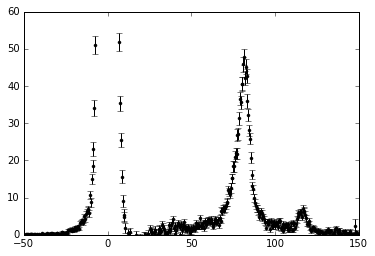

In [6]:
ws = mtd[wsname+'_cf']
plt.errorbar(ws.readX(0)[1:], ws.readY(0), yerr=ws.readE(0), fmt='.k')
plt.ylim([0,60])

Now we fit a Gaussian function to the elastic line and define a `Background` for the `CrystalField` object, and fix its parameters so it doesn't vary during the fit.

In [7]:
# Fit a Gaussian function to the elastic line
Fit(Function='name=Gaussian,Height=55,PeakCentre=0,Sigma=5', 
    InputWorkspace=wsname+'_cf', Output=wsname+'_cf', OutputCompositeMembers=True)
parvals = mtd[wsname+'_cf_Parameters'].column(1)
parsG = {pnames:parvals[id] for id,pnames in enumerate(mtd[wsname+'_cf_Parameters'].column(0))}
print parsG

{'PeakCentre': -0.4914084449619318, 'Sigma': 3.168744358068005, 'Cost function value': 33.72274647712888, 'Height': 778.4653908820262}


Now we define a resolution function, using `PyChop`

In [8]:
from PyChop import PyChop2
from CrystalField import ResolutionModel

# Set up a resolution model for MARI
mari = PyChop2('MARI', 'S', 600)
mari.setEi(200)
resmod = ResolutionModel(mari.getResolution, xstart=-200, xend=199)

Now we define a crystal field model, with some random starting parameters and then try to use the `estimate_parameters` method to determine better starting parameters. 

In order to help this process along, we fix all the peak widths using the resolution function and fix the elastic peak to what we previously fitted. This means that only the crystal field parameters will be varied in the `estimate_parameters` routine and subsequent fit.

In [9]:
from CrystalField import CrystalField, CrystalFieldFit, Background, Function

# Generates a random set of parameters
nonzero_parameters = ['B20', 'B40', 'B60', 'B43', 'B63', 'B66']
Blm = {}
for pname in nonzero_parameters:
    Blm[pname] = np.random.rand()*2-1

# Set up a CrystalField model
cf = CrystalField('Yb', 'D3d', Temperature=100, ResolutionModel=resmod, **Blm)
#    B20=1.135, B40=-0.0615, B43=0.315, B60=0.0011, B63=0.037, B66=0.005)
# Define a background function for the CrystalField Model
cf.background = Background(peak=Function('Gaussian', Height=parsG['Height'], Sigma=parsG['Sigma']),
    background=Function('LinearBackground', A0=0, A1=0))
# Fixes the background parameters, so that estimate_parameters only varies the CF parameters
cf.background.peak.ties(Height=parsG['Height'], Sigma=parsG['Sigma'])
cf.background.background.ties(A0=0, A1=0)
cf.IntensityScaling=1
cf.ties(IntensityScaling=1)

# Runs the estimate_parameters algorithm to find a decent set of initial parameters
cffit = CrystalFieldFit(cf, InputWorkspace=wsname+'_cf')
cffit.estimate_parameters(EnergySplitting=100, Parameters=nonzero_parameters, NSamples=1000)
print 'Returned', cffit.get_number_estimates(), 'sets of parameters.'
cffit.select_estimated_parameters(1)
print 'Best guess parameters:'
for pname in nonzero_parameters:
    print '%s = %5.3g' % (pname, cf[pname])
    
# Reruns the fit on these parameters
cffit.fit()
Blmfit = {pname:cf[pname] for pname in nonzero_parameters}
print 'Fitted parameters:'
for pname in nonzero_parameters:
    print '%s = %5.3g' % (pname, cf[pname])

Returned 10 sets of parameters.
Best guess parameters:
B20 = -2.16
B40 = 0.00316
B60 = -0.00178
B43 = -0.302
B63 = 0.0123
B66 = 0.0356
Fitted parameters:
B20 = -2.07
B40 = 0.0136
B60 = -0.000823
B43 = -0.0313
B63 = 0.0163
B66 = 0.0428


C:/MantidInstall/scripts/Inelastic\CrystalField\energies.py:38: FutureWarning: This function is under development and can be changed/removed in the future
  FutureWarning)


Finally, we calculate the fitted spectrum and plot it.

(0, 60)

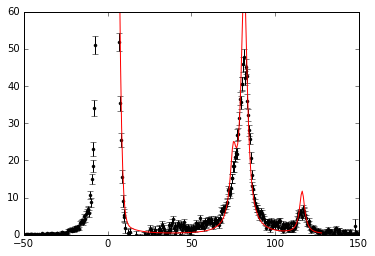

In [10]:
# Calculates the resulting crystal field spectrumInfo
cf = CrystalField('Yb', 'D3d', Temperature=100, ResolutionModel=resmod, **Blmfit)
# Define a background function for the CrystalField Model
cf.background = Background(peak=Function('Gaussian', Height=parsG['Height'], Sigma=parsG['Sigma']),
    background=Function('LinearBackground', A0=0, A1=0))
cf.IntensityScaling=1    
x,y = cf.getSpectrum()
ws_fit = CreateWorkspace(x,y)
ws = mtd[wsname+'_cf']
plt.errorbar(ws.readX(0)[1:], ws.readY(0), yerr=ws.readE(0), fmt='.k')
plt.plot(x,y,'-r')
plt.ylim([0,60])

We can also calculate the physical properties and compare to published data.

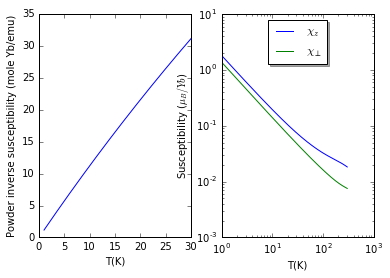

In [11]:
T1,invchi = cf.getSusceptibility(Temperature=np.linspace(1,30,300), Unit='cgs', Inverse=True, Hdir='powder')
T2,chipar = cf.getSusceptibility(Temperature=np.linspace(1,300,300), Unit='bohr', Inverse=False, Hdir=[0,0,1])
T3,chiperp = cf.getSusceptibility(Temperature=np.linspace(1,300,300), Unit='bohr', Inverse=False, Hdir=[1,0,0])

plt.subplot(121)
plt.plot(T1,invchi)
plt.xlabel('T(K)')
plt.ylabel('Powder inverse susceptibility (mole Yb/emu)')
plt.subplot(122)
plt.plot(T2,chipar,label='$\chi_z$')
plt.plot(T3,chiperp,label='$\chi_{\perp}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('T(K)')
plt.ylabel('Susceptibility ($\mu_B/Yb$)')
plt.legend(loc='upper center', shadow=True)

Compare to data measured by *J. Phys.: Condens. Matter* **21** (2009) 492202:
<img src="cao_yb2ti2o7_chi.png",width=800>


Finally we can calculate the magnetisation in the $x$, $y$, and $z$ directions:

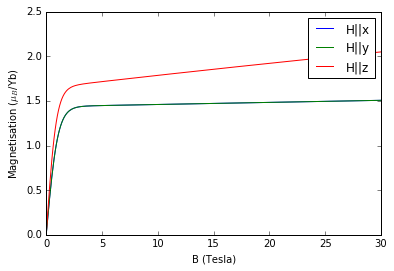

In [12]:
H1,ws_magx = cf.getMagneticMoment(Hmag=np.linspace(0,30,300), Unit='bohr', Inverse=False, Hdir=[1,0,0])
H2,ws_magy = cf.getMagneticMoment(Hmag=np.linspace(0,30,300), Unit='bohr', Inverse=False, Hdir=[0,1,0])
H3,ws_magz = cf.getMagneticMoment(Hmag=np.linspace(0,30,300), Unit='bohr', Inverse=False, Hdir=[0,0,1])

plt.plot(H1,ws_magx,label='H||x')
plt.plot(H2,ws_magy,label='H||y')
plt.plot(H3,ws_magz,label='H||z')
plt.legend()
plt.xlabel('B (Tesla)')
plt.ylabel('Magnetisation ($\mu_B$/Yb)')

We see that the saturation is larger for the $x$ and $y$ directions, indicating it is magnetically 'easier'. Hence this material has a planar type anisotropy.

We know that the ground state is $|J_z = \pm \frac{1}{2}\rangle$ which means that the magnetisation along $z$ should be minimised (hence the magnetisation perpendicular to $z$ is maximised). An easy-axis type anisotropy would instead have a $|J_z = \pm \frac{7}{2}\rangle$ ground state, which would seek to maximise the magnetisation along $z$.

Finally we print out the eigenvector matrix and check that the ground state really *is* $|J_z=\pm\frac{1}{2}\rangle$.

In [13]:
np.set_printoptions(precision=4, linewidth=140, suppress=True)
print cf.getEigenvectors()

[[-0.0000+0.j  0.8102+0.j  0.0000-0.j  0.0000+0.j  0.0848+0.j -0.5441+0.j  0.0038+0.j  0.2010+0.j]
 [-0.5861+0.j -0.0000+0.j  0.0000-0.j  0.0000+0.j  0.7459+0.j  0.1162+0.j -0.2942+0.j  0.0056+0.j]
 [-0.0000+0.j  0.0000+0.j -1.0000-0.j  0.0000+0.j  0.0000+0.j -0.0000+0.j -0.0000+0.j -0.0000+0.j]
 [ 0.0000+0.j -0.0103+0.j  0.0000-0.j  0.0000+0.j  0.0548+0.j -0.3519+0.j -0.0179+0.j -0.9342+0.j]
 [ 0.0103+0.j  0.0000+0.j -0.0000-0.j -0.0000+0.j -0.3519+0.j -0.0548+0.j -0.9342+0.j  0.0179+0.j]
 [ 0.0000+0.j  0.0000+0.j  0.0000-0.j  1.0000+0.j -0.0000+0.j -0.0000+0.j -0.0000+0.j  0.0000+0.j]
 [-0.0000+0.j -0.5861+0.j  0.0000-0.j  0.0000+0.j  0.1162+0.j -0.7459+0.j  0.0056+0.j  0.2942+0.j]
 [ 0.8102+0.j  0.0000+0.j  0.0000-0.j  0.0000+0.j  0.5441+0.j  0.0848+0.j -0.2010+0.j  0.0038+0.j]]
